# 1. Setup

## Load libraries

In [152]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from sklearn.utils import class_weight
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from time import time

In [4]:
ASSETS = './assets/'

# 2. Explore data

## Number of images per a set

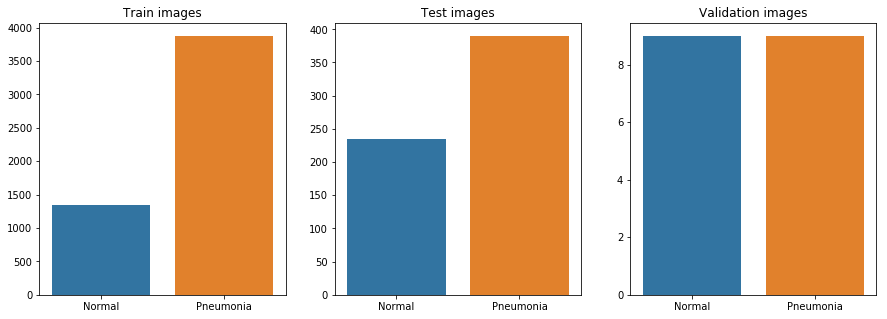

In [33]:
plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

def display_image_counts(images_set, index, label):
    normal_count = len(os.listdir(f'{ASSETS}{images_set}/NORMAL'))
    pneumonia_count = len(os.listdir(f'{ASSETS}{images_set}/PNEUMONIA'))
    plt.subplot(1, 3, index)
    plt.title(label)
    sns.barplot(x=['Normal', 'Pneumonia'], y=[normal_count, pneumonia_count])

display_image_counts('train', 1, 'Train images')
display_image_counts('test', 2, 'Test images')
display_image_counts('val', 3, 'Validation images')

plt.show()

## Display sample images from each set

train - NORMAL


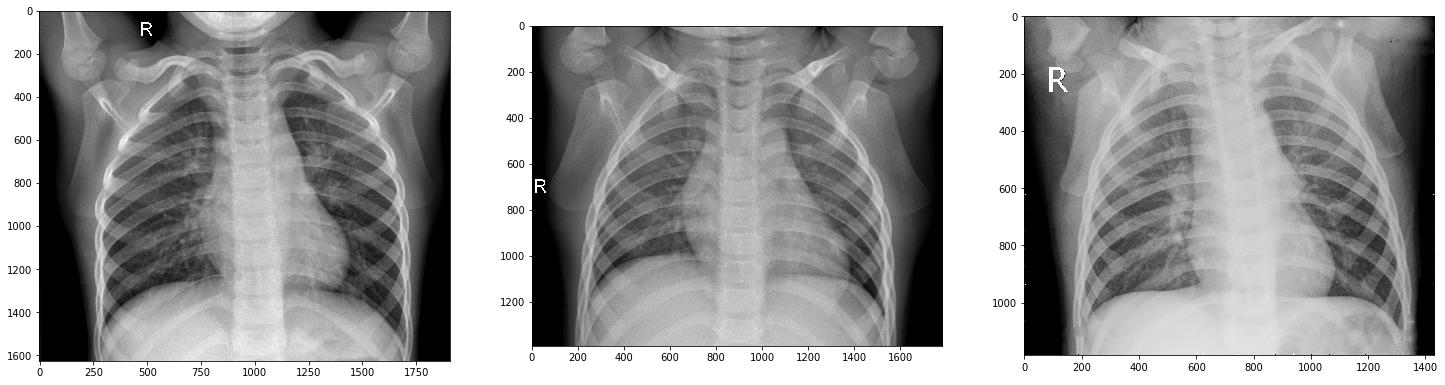

train - PNEUMONIA


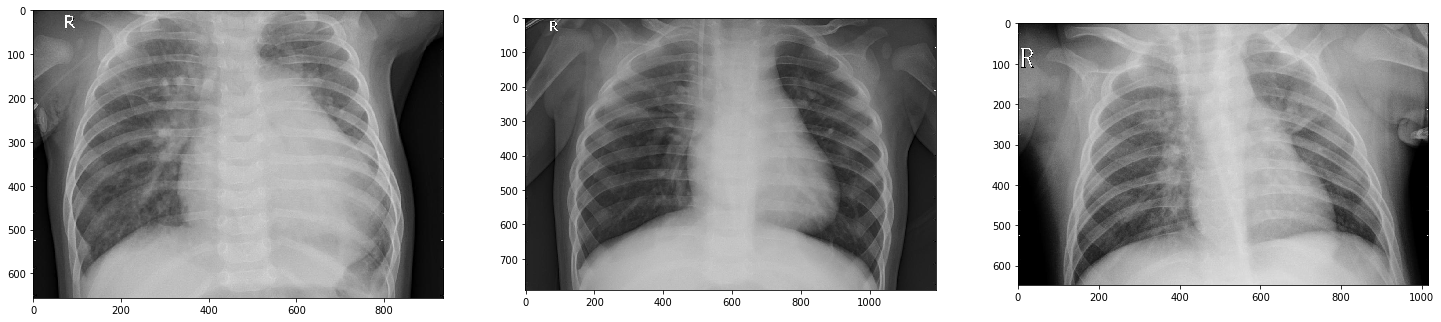

test - NORMAL


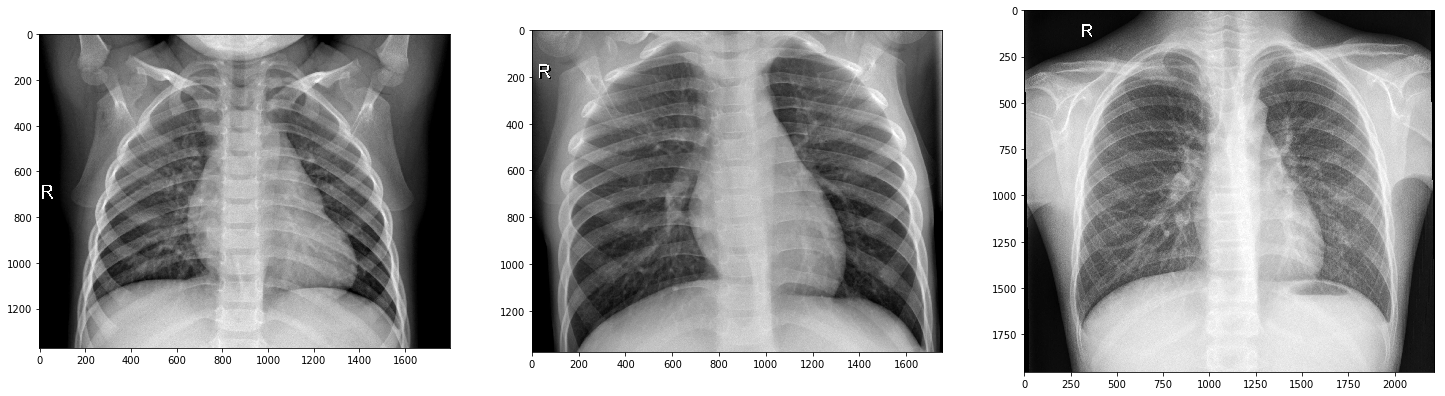

test - PNEUMONIA


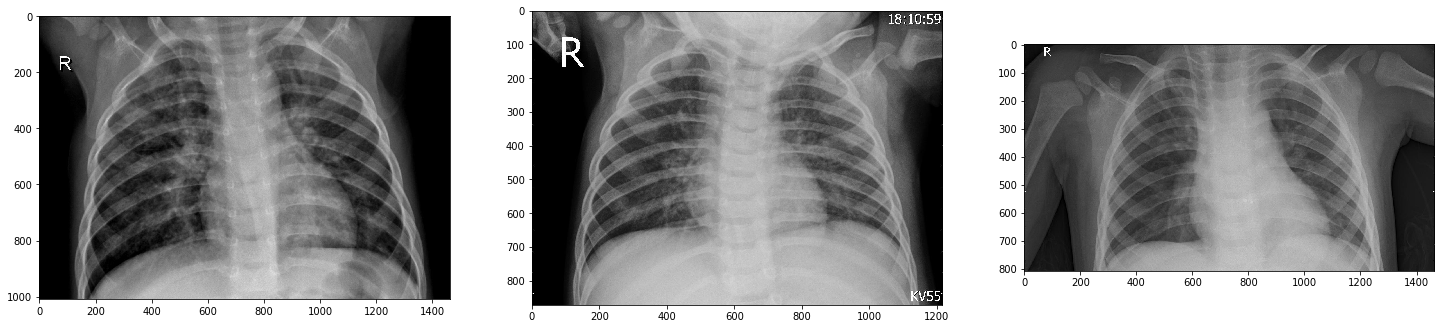

val - NORMAL


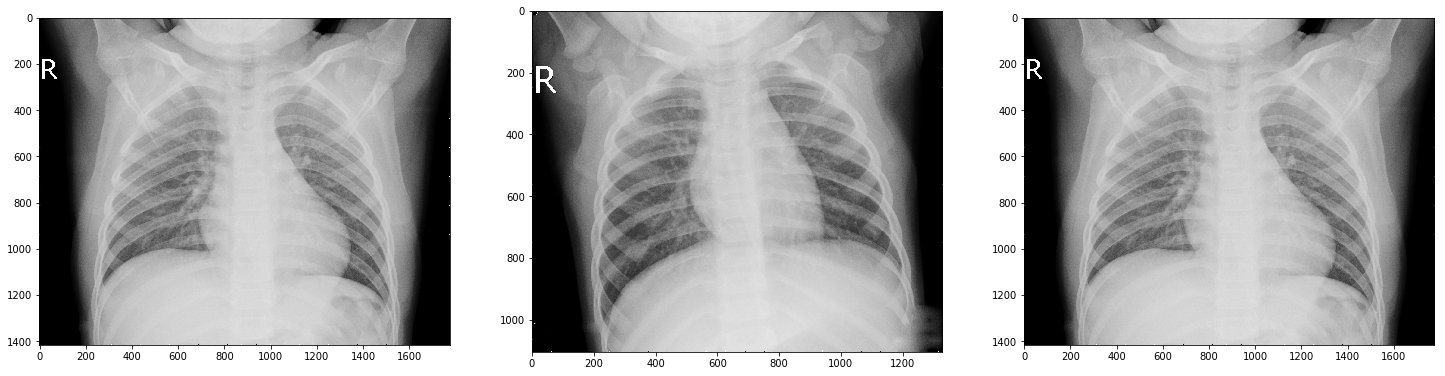

val - PNEUMONIA


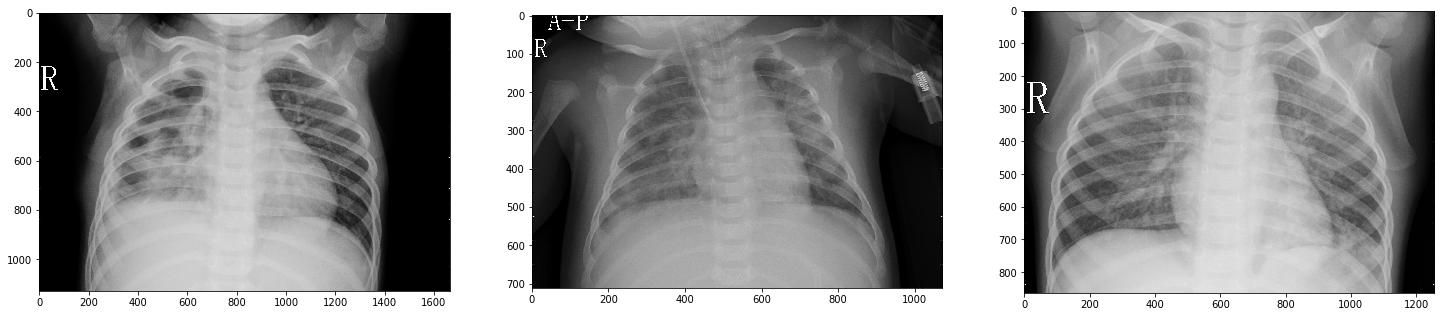

In [75]:
def list_images(images_set, images_class, count = 3):
    print(f'{images_set} - {images_class}')
    plt.subplots(nrows=1, ncols=5, figsize=(25, 25))

    folder_path = f'{ASSETS}{images_set}/{images_class}'
    image_paths = glob.glob(f'{folder_path}/*.jpeg')
    selected_image_paths = np.random.choice(image_paths, count)

    for idx, image_path in enumerate(selected_image_paths):
        image = cv2.imread(image_path)
        plt.subplot(1, count, idx + 1)
        plt.imshow(image)
    plt.show()

list_images('train', 'NORMAL')
list_images('train', 'PNEUMONIA')

list_images('test', 'NORMAL')
list_images('test', 'PNEUMONIA')

list_images('val', 'NORMAL')
list_images('val', 'PNEUMONIA')

# 3. Model definition

## Tensorflow generators

In [136]:
rescale = 1./255
target_size = (150, 150)
batch_size = 128
class_mode = 'binary'

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=[-10, 10],
    height_shift_range=[-10, 10],
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    f'{ASSETS}train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode
)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    f'{ASSETS}test',
    target_size=target_size,
    class_mode=class_mode
)

val_datagen = ImageDataGenerator(rescale=rescale)

val_generator = val_datagen.flow_from_directory(
    f'{ASSETS}val',
    target_size=target_size,
    class_mode=class_mode
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## InceptionV3 model

### Load original model

In [145]:
inception_model = InceptionV3(
    weights=None,
    include_top=False, 
    input_shape=(150, 150, 3)
)
inception_model.load_weights(f'{ASSETS}inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

for layer in inception_model.layers:
    layer.trainable = False

### Add custom final layers & compile

In [151]:
x = inception_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inception_model.input, outputs=x)

model.summary()

model.compile(
    optimizer=Adam(lr=1e-4),
    loss='binary_crossentropy', 
    metrics=['accuracy'])

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_479 (BatchN (None, 74, 74, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_479[0][0]    
___________________________________________________________________________________________

## Training the model

### Calculate class weights for paying more attention to under-represented classs

In [119]:
class_weights = class_weight.compute_class_weight(
    'balanced', 
    np.unique(train_generator.classes), 
    train_generator.classes
)
print('Class weights:', class_weights)

Class weights: [1.9448173  0.67303226]


### Callbacks

In [154]:
lr_reduction_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=1e-12,
    patience=4,
    cooldown=5,
    verbose=1
)
callbacks = [lr_reduction_cb]

### Train the model

In [155]:
start_time = time()

history = model.fit_generator(
    train_generator,
    steps_per_epoch=128,
    epochs=10,
    verbose=2,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=callbacks,
    class_weight=class_weights
)

print('Training time: ', time() - start_time)

Epoch 1/10
128/128 - 268s - loss: 0.2508 - accuracy: 0.8962 - val_loss: 0.7312 - val_accuracy: 0.6875
Epoch 2/10
128/128 - 264s - loss: 0.1766 - accuracy: 0.9326 - val_loss: 0.5866 - val_accuracy: 0.7388
Epoch 3/10
128/128 - 259s - loss: 0.1577 - accuracy: 0.9374 - val_loss: 0.5779 - val_accuracy: 0.7564
Epoch 4/10
128/128 - 254s - loss: 0.1524 - accuracy: 0.9429 - val_loss: 0.6523 - val_accuracy: 0.7131
Epoch 5/10
128/128 - 255s - loss: 0.1526 - accuracy: 0.9393 - val_loss: 0.9903 - val_accuracy: 0.6987
Epoch 6/10
128/128 - 265s - loss: 0.1441 - accuracy: 0.9435 - val_loss: 0.6389 - val_accuracy: 0.7147
Epoch 7/10

Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-17.
128/128 - 266s - loss: 0.1389 - accuracy: 0.9447 - val_loss: 0.6946 - val_accuracy: 0.6795
Epoch 8/10
128/128 - 257s - loss: 0.1310 - accuracy: 0.9490 - val_loss: 0.6946 - val_accuracy: 0.6795
Epoch 9/10
128/128 - 276s - loss: 0.1295 - accuracy: 0.9504 - val_loss: 0.6946 - val_accuracy: 0.6795
E

In [157]:
model.save('./artifacts/model.h5')

### Loss and accuracy over epochs

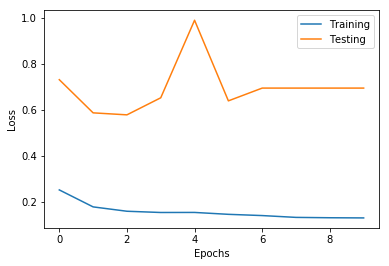

In [160]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

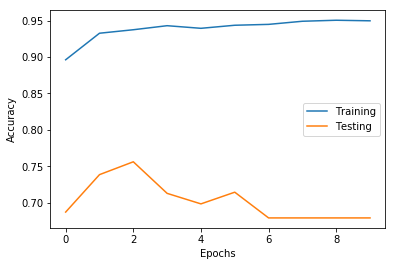

In [163]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

## Verifying the model

In [164]:
class_map = {v: k for k, v in test_generator.class_indices.items()}
class_map

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [214]:
def verify_predictions(images_set, images_class, count = 8):
    print(f'{images_set} - {images_class}')
    plt.subplots(nrows=1, ncols=5, figsize=(25, 25))

    folder_path = f'{ASSETS}{images_set}/{images_class}'
    image_paths = glob.glob(f'{folder_path}/*.jpeg')
    selected_image_paths = np.random.choice(image_paths, count)

    for idx, image_path in enumerate(selected_image_paths):
        image = cv2.imread(image_path)
        plt.subplot(1, count, idx + 1)
        plt.imshow(image)
        image = cv2.resize(image, (150, 150))
        prediction = model.predict(np.array([image]))
        predicted_class = class_map[int(prediction[0, 0])]
        plt.title(f'Class: {images_class}\nPredicted: {predicted_class}')
    plt.show()

Prediction on the test dataset

test - NORMAL


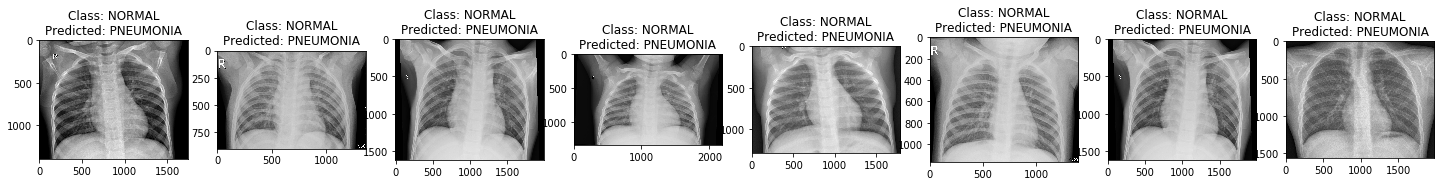

test - PNEUMONIA


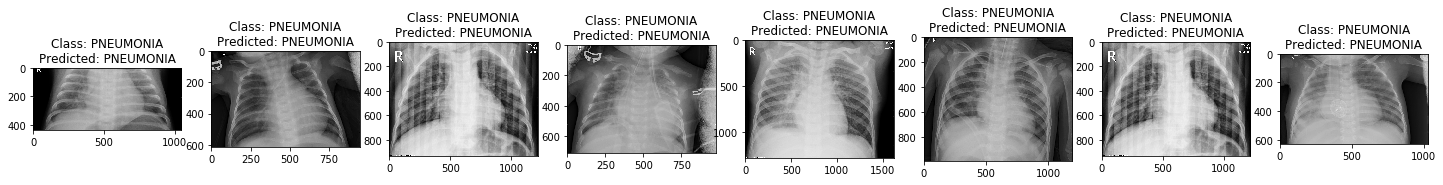

In [215]:
verify_predictions('test', 'NORMAL')
verify_predictions('test', 'PNEUMONIA')

Prediction on the validation datatset

val - NORMAL


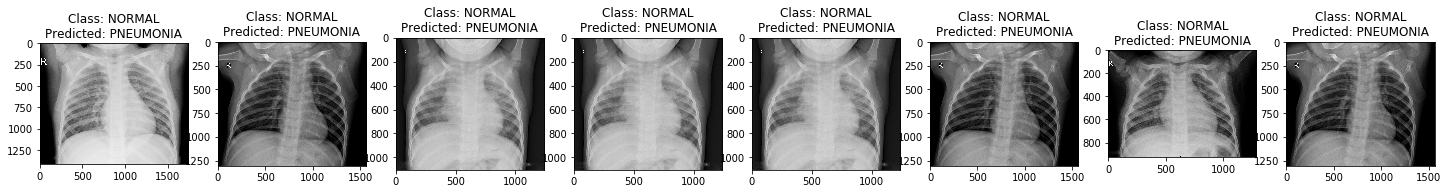

val - PNEUMONIA


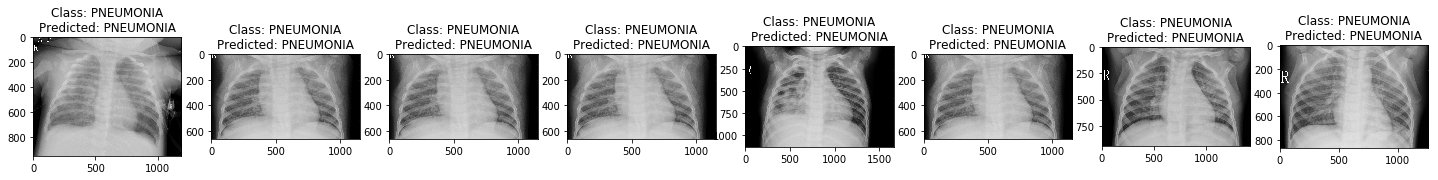

In [216]:
verify_predictions('val', 'NORMAL')
verify_predictions('val', 'PNEUMONIA')